In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pyamg
import scipy.sparse.linalg as sla
import numpy as np
import time

# Load the sparse matrix

In [20]:
if 1:
    A = pyamg.gallery.poisson((100,100), format='csr')
    n = A.shape[0]
    b = np.ones((n,))
    x = A * b
    x0 = np.random.rand(n)
if 0:
    #A= sio.mmread('mesh_2d_h005.mtx.gz')
    A = sio.mmread('horseshoe_matrix_anisotropic.mtx.gz')
    n = A.shape[0]
    b = np.ones((n,))
    x = A * b
    x0 = np.random.rand(n)
print(A.nnz)

49600


# Create ILU and LU

Here we will generate the ILU/LU using difference reorderings `permc_spec`

In [26]:
t = time.time()
B = sla.spilu(A, drop_tol=1e-12, fill_factor=1)#, permc_spec='NATURAL')
tilu = time.time() - t

t = time.time()
C = sla.splu(A)#, permc_spec='NATURAL')
tlu = time.time() - t

Mz = lambda r: B.solve(r)
Minv = sla.LinearOperator(A.shape, Mz)

print("nnz in A: %d"%A.nnz)
print("nnz in B: %d"%B.nnz)
print("nnz in C: %d"%C.nnz)
print("time for ILU: %g"%tilu)
print("time for  LU: %g"%tlu)

nnz in A: 49600
nnz in B: 61246
nnz in C: 663314
time for ILU: 0.0164001
time for  LU: 0.032419


/usr/local/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:299: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/usr/local/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:237: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


# Check out the sparsity

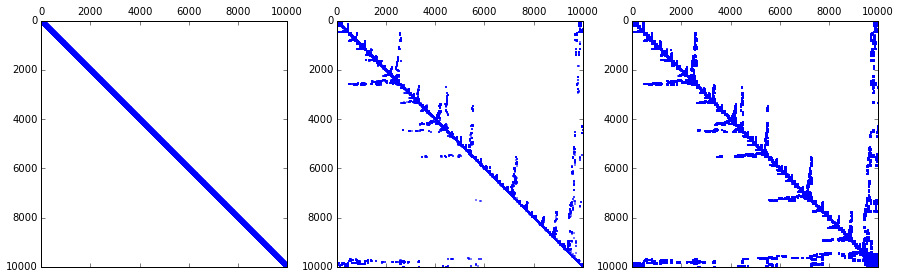

In [6]:
f, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].spy(A, marker='.', ms=2)
ax[1].spy(B.L + B.U, marker='.', ms=2)
ax[2].spy(C.L + C.U, marker='.', ms=2)

# How fast is the SpMV?

In [7]:
t = time.time()
Minv.matvec(b)
tspmv = time.time() - t
print("time to solve: %g"%tspmv)

time to solve: 0.00100684


#### What is the equivalant number of SpMVs?

In [27]:
tilu / tspmv

16.288657352592942

# RUN GMRES vs PGMRES

In [30]:
res0 = []
t = time.time()
x = pyamg.krylov.gmres(A, b, x0=x0, tol=1e-8, restrt=20, maxiter=100, M=None, residuals=res0)
t = time.time() - t
print("time for  gmres: %g"%t)
res1 = []
t = time.time()
x = pyamg.krylov.gmres(A, b, x0=x0, tol=1e-8, restrt=20, maxiter=100, M=Minv, residuals=res1)
t = time.time() - t
print("time for pgmres: %g"%t)

time for  gmres: 0.930835
time for pgmres: 0.836835


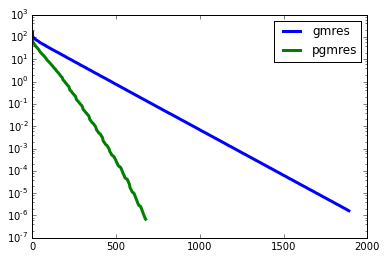

In [31]:
plt.semilogy(res0, lw=3, label='gmres')
plt.hold(True)
plt.semilogy(res1, lw=3, label='pgmres')
plt.legend()

# Now vary the parameters

Two parameters play a role here:
`fill_factor`
and
`drop_tol`

nnz in A: 49600
time for    ILU: 0.0265751
time for pgmres: 0.859281


/usr/local/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:299: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


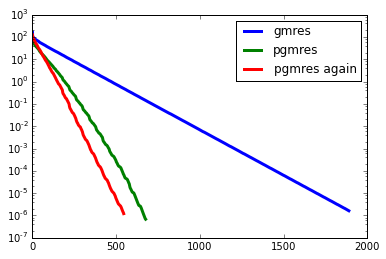

In [36]:
t = time.time()
B = sla.spilu(A, drop_tol=1e-11, fill_factor=2)
tilu = time.time() - t

Mz = lambda r: B.solve(r)
Minv = sla.LinearOperator(A.shape, Mz)

res2 = []
t = time.time()
x = pyamg.krylov.gmres(A, b, x0=x0, tol=1e-8, restrt=20, maxiter=100, M=Minv, residuals=res2)
t = time.time() - t

print("nnz in A: %d"%A.nnz)
print("time for    ILU: %g"%tilu)
print("time for pgmres: %g"%t)

plt.semilogy(res0, lw=3, label='gmres')
plt.hold(True)
plt.semilogy(res1, lw=3, label='pgmres')
plt.semilogy(res2, lw=3, label='pgmres again')
plt.legend()

# Look ahead: (algebraic) multigrid

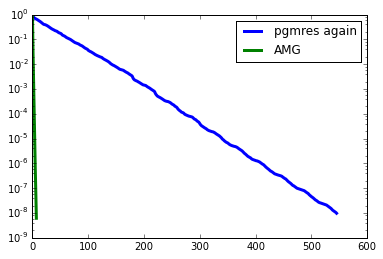

In [38]:
ml = pyamg.smoothed_aggregation_solver(A, max_coarse=10)
resmg = []
x = ml.solve(b, x0=x0, residuals=resmg, accel='gmres', tol=1e-8)
plt.hold(True)

res2 = np.array(res2) / res2[0]
resmg = np.array(resmg) / resmg[0]
plt.semilogy(res2, lw=3, label='pgmres again')
plt.semilogy(resmg, lw=3, label='AMG')
plt.legend()